#### Este notebook muestra el proceso de entrenamiento del modelo YOLO11m

In [1]:
#IMPORTAMOS LIBRERIAS
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
warnings.filterwarnings('ignore')

In [2]:
#VERIFICAMOS SI TENEMOS NUESTRA GPU DISPONIBLE Y LAS VERSIONES DE PYTORCH Y CUDA
import torch
import torchvision

print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0)) 
print("Version Pytorch:", torch.__version__)
print("Version Torchvision:", torchvision.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

True
NVIDIA GeForce RTX 4050 Laptop GPU
Version Pytorch: 2.5.1+cu118
Version Torchvision: 0.20.1+cu118
CUDA disponible: True
CUDA version: 11.8


In [3]:
#Importamos los datos necesarios para el entrenamiento
train_images = 'Dataset 4K_9K/train4k_9k/images'
train_labels = 'Dataset 4K_9K/train4k_9k/labels'

test_images = 'Dataset 4K_9K/test4k_9k/images'
test_labels = 'Dataset 4K_9K/test4k_9k/labels'

val_images = 'Dataset 4K_9K/valid4k_9k/images'
val_labels = 'Dataset 4K_9K/valid4k_9k/labels'

In [4]:
print('Numero de imagenes de entrenamiento: ' + str(len(os.listdir(train_images))))
print('Numero de etiquetas de entrenamiento: ' + str(len(os.listdir(train_labels))))
print('Numero de imagenes de validacion: ' + str(len(os.listdir(val_images))))
print('Numero de etiquetas de validacion ' + str(len(os.listdir(val_labels))))
print('Numero de imagenes de testeo: ' + str(len(os.listdir(test_images))))
print('Numero de etiquetas de testeo ' + str(len(os.listdir(test_labels))))
print('Total imagenes: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Numero de imagenes de entrenamiento: 10246
Numero de etiquetas de entrenamiento: 10246
Numero de imagenes de validacion: 2294
Numero de etiquetas de validacion 2294
Numero de imagenes de testeo: 1052
Numero de etiquetas de testeo 1052
Total imagenes: 13592


In [10]:
#ANALISIS DE FORMATO CORRECTO DE ETIQUETAS YOLO
def verify_yolo_labels(labels_dir):
    errors = []
    required_columns = 5
    class_id = 0  
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue            
        file_path = os.path.join(labels_dir, label_file)     
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()                
                for line_num, line in enumerate(lines, 1):
                    line = line.strip()                    
                    if not line:
                        continue                         
                    parts = line.split()
                    
                    if len(parts) != required_columns:
                        errors.append(f"{label_file} línea {line_num}: Número incorrecto de valores ({len(parts)} en lugar de 5)")
                        continue
                    try:
                        cls = int(parts[0])
                        if cls != class_id:
                            errors.append(f"{label_file} línea {line_num}: Clase incorrecta ({cls} en lugar de 0)")
                    except ValueError:
                        errors.append(f"{label_file} línea {line_num}: Formato de clase inválido ('{parts[0]}')")
                    
                    for i, coord in enumerate(parts[1:], start=1):
                        try:
                            num = float(coord)
                            if not (0.0 <= num <= 1.0):
                                errors.append(f"{label_file} línea {line_num}: Valor {['x_center', 'y_center', 'width', 'height'][i-1]} ({num}) fuera de rango [0, 1]")
                        except ValueError:
                            errors.append(f"{label_file} línea {line_num}: Formato numérico inválido en posición {i} ('{coord}')")                    
                    try:
                        width = float(parts[3])
                        height = float(parts[4])
                        if width <= 0 or height <= 0:
                            errors.append(f"{label_file} línea {line_num}: Bounding box con tamaño inválido (ancho: {width}, alto: {height})")
                    except:
                        pass                         
        except Exception as e:
            errors.append(f"{label_file}: Error al leer archivo - {str(e)}")
            
    return errors

In [15]:
def verification_labels(directory, name):
    labels_directory = directory
    errors = verify_yolo_labels(labels_directory)
    if errors:
        print(f"Se encontraron {len(errors)} errores:")
        for error in errors:
            print(f"• {error}")
    else:
        print(f"Todos los archivos de etiquetas del conjunto {name} están correctos")


In [16]:
verification_labels("Dataset 4K_9K/train4k_9k/labels", "Train")
verification_labels("Dataset 4K_9K/valid4k_9k/labels", "Test")
verification_labels("Dataset 4K_9K/test4k_9k/labels", "Validation")

Todos los archivos de etiquetas del conjunto Train están correctos
Todos los archivos de etiquetas del conjunto Test están correctos
Todos los archivos de etiquetas del conjunto Validation están correctos


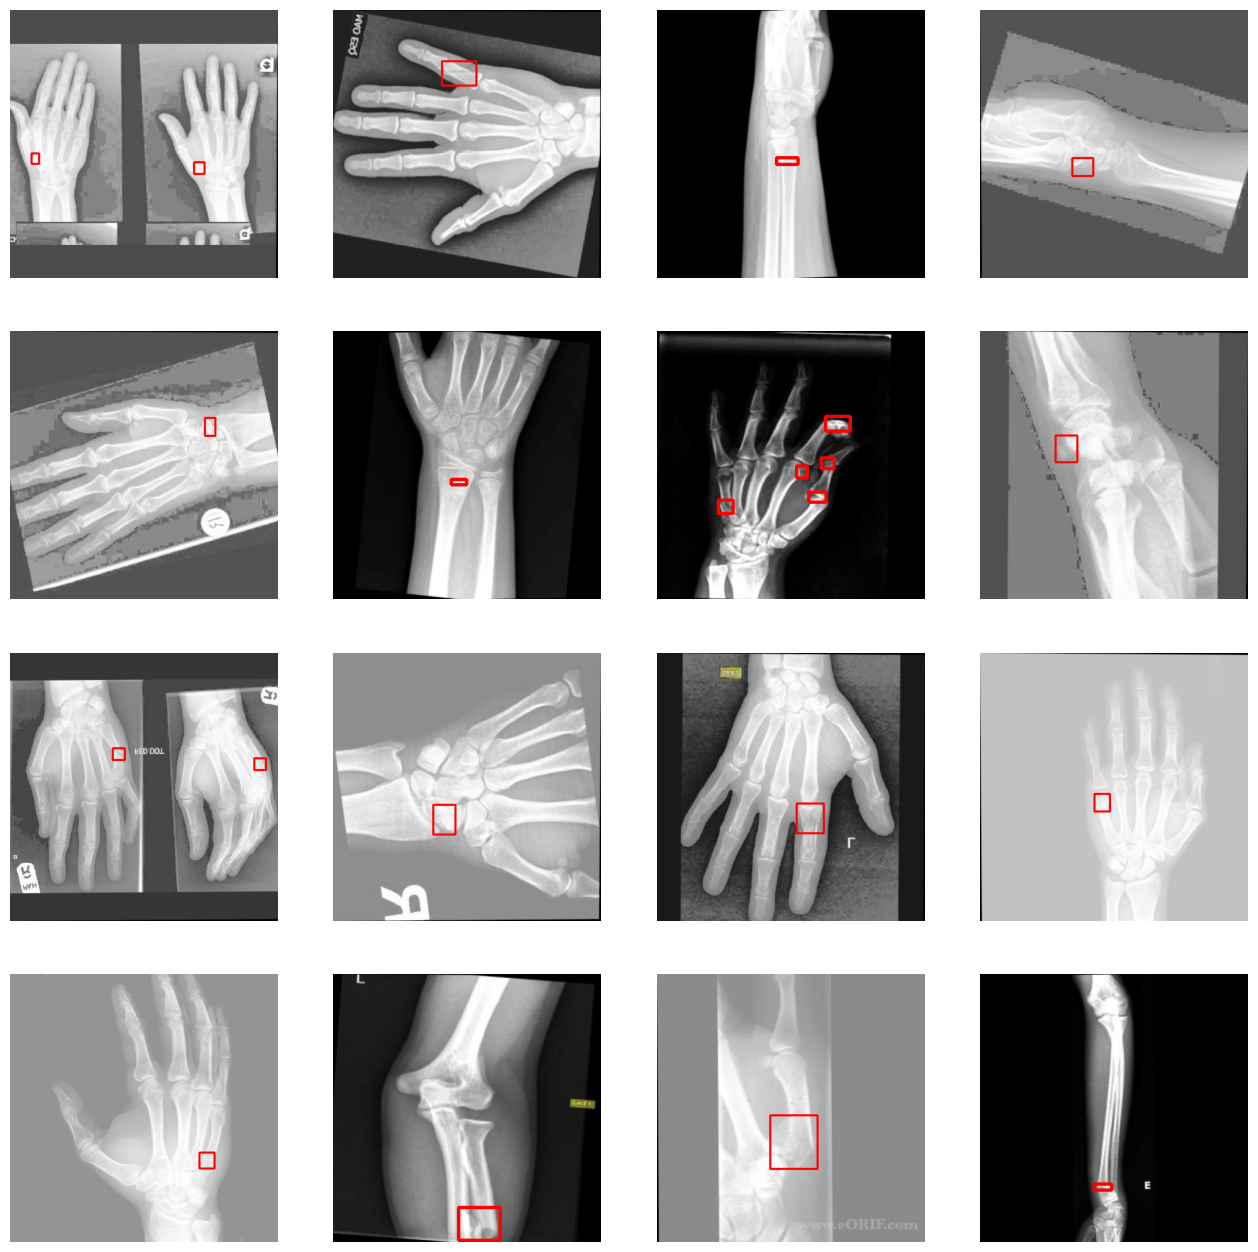

In [6]:
#VISUALZACION DE IMAGENES DEL CONJUNTO DE ENTRENAMIENTO
image_files = os.listdir(train_images)
random_images = random.sample(image_files, 16)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))


for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
        
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0,0, 255), 3)

    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [36]:
#CARGA MODELO YOLO11M
model_v11 = YOLO("yolo11m.pt")

In [7]:
#ENTRENAMIENTO MODELO
model_v11.train(data = 'data4k_9k.yaml',
            epochs = 35,
            imgsz = 512,
            batch=16,
            workers=8,
            overlap_mask=True,
            name = "model_v11" )

New https://pypi.org/project/ultralytics/8.3.49 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.31  Python-3.9.20 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolo11m.pt, data=data4k_9k.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model_v112, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals

train: Scanning C:\Users\zekro\Desktop\Ivan\PostGradoUMSS\Estadistica\Final Project\YOLO-ROBOFLOW\Fracture_Detection_yo
val: Scanning C:\Users\zekro\Desktop\Ivan\PostGradoUMSS\Estadistica\Final Project\YOLO-ROBOFLOW\Fracture_Detection_yolo


Plotting labels to runs\detect\model_v112\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\model_v112
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      5.59G      2.795      3.356       2.01         19        512: 100%|██████████| 641/641 [05:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:32


                   all       2294       2872     0.0827      0.016     0.0111    0.00289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      5.59G      2.748      3.188      1.908         17        512: 100%|██████████| 641/641 [05:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [02:38


                   all       2294       2872     0.0755     0.0637     0.0226    0.00688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35       5.6G      2.652      3.033      1.847         17        512: 100%|██████████| 641/641 [04:50<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:35


                   all       2294       2872      0.115     0.0602      0.035     0.0107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      5.58G       2.58      2.918       1.79         11        512: 100%|██████████| 641/641 [04:46<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [02:09


                   all       2294       2872      0.175       0.13     0.0805     0.0236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      5.65G      2.507      2.779      1.754          7        512: 100%|██████████| 641/641 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:45


                   all       2294       2872      0.192      0.119     0.0781     0.0242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      5.63G      2.441      2.651      1.703         11        512: 100%|██████████| 641/641 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:51


                   all       2294       2872      0.237      0.174      0.128     0.0428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      5.63G      2.403      2.577      1.674         11        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:41


                   all       2294       2872      0.229      0.114     0.0872     0.0275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      5.58G      2.348       2.49      1.652         12        512: 100%|██████████| 641/641 [04:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:51


                   all       2294       2872      0.263      0.192      0.153     0.0511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      5.64G      2.349      2.459      1.641          7        512: 100%|██████████| 641/641 [04:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:38


                   all       2294       2872      0.294      0.199      0.159      0.052

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      5.63G      2.302      2.379       1.62         16        512: 100%|██████████| 641/641 [04:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:37


                   all       2294       2872      0.317      0.229      0.181     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      5.67G      2.309      2.361       1.63          7        512: 100%|██████████| 641/641 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:47


                   all       2294       2872      0.366      0.291      0.252     0.0872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      5.58G      2.256      2.274      1.588          5        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [02:05


                   all       2294       2872      0.347      0.269      0.229      0.079

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      5.64G      2.242      2.238       1.58         12        512: 100%|██████████| 641/641 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:45


                   all       2294       2872      0.399       0.31      0.294      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      5.64G      2.229      2.182      1.563          6        512: 100%|██████████| 641/641 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:36


                   all       2294       2872       0.38      0.331      0.289      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      5.63G      2.197      2.149      1.547         11        512: 100%|██████████| 641/641 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [02:01


                   all       2294       2872      0.443      0.372      0.343      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      5.58G      2.175      2.089      1.549         11        512: 100%|██████████| 641/641 [04:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:37


                   all       2294       2872      0.374      0.301       0.26     0.0892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      5.64G       2.16      2.061      1.529          8        512: 100%|██████████| 641/641 [04:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:35


                   all       2294       2872      0.458      0.351      0.332      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      5.63G      2.153      2.043      1.522          7        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:38


                   all       2294       2872      0.398      0.287      0.263     0.0952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      5.64G      2.126      1.991       1.53          9        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:12


                   all       2294       2872      0.522      0.402      0.405      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      5.58G      2.129      1.969      1.525         14        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:29


                   all       2294       2872      0.506      0.405      0.403      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      5.63G      2.086      1.912      1.493          6        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:40


                   all       2294       2872      0.539      0.411      0.431      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      5.63G       2.06      1.866      1.488          9        512: 100%|██████████| 641/641 [04:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:45


                   all       2294       2872      0.552      0.441      0.453      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      5.64G      2.064      1.826      1.483         10        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:45


                   all       2294       2872      0.584      0.455      0.476      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      5.57G      2.034      1.791      1.464          5        512: 100%|██████████| 641/641 [04:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:28

                   all       2294       2872       0.58      0.459       0.48      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      5.63G      2.011      1.764      1.456         10        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:58


                   all       2294       2872      0.599      0.467      0.487      0.183
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      5.63G       1.99      1.707      1.518          8        512: 100%|██████████| 641/641 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:45

                   all       2294       2872      0.609      0.483      0.503      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      5.62G      1.968      1.654      1.515          6        512: 100%|██████████| 641/641 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:50

                   all       2294       2872       0.64      0.474       0.51      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      5.57G      1.933        1.6      1.495          6        512: 100%|██████████| 641/641 [04:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:36

                   all       2294       2872      0.636      0.485      0.518      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      5.64G      1.922      1.571      1.496          7        512: 100%|██████████| 641/641 [04:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:42

                   all       2294       2872      0.642      0.499      0.541      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      5.62G      1.893      1.534      1.475          8        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:37

                   all       2294       2872      0.663      0.508      0.545      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      5.63G      1.869      1.495      1.465          7        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:33

                   all       2294       2872       0.66      0.517      0.564       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      5.57G      1.855      1.456      1.449          8        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:27

                   all       2294       2872      0.685      0.535      0.576      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      5.63G      1.835      1.433      1.443          8        512: 100%|██████████| 641/641 [04:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:37

                   all       2294       2872      0.706      0.532       0.58       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      5.62G      1.826       1.39      1.435          6        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:46

                   all       2294       2872      0.688       0.55      0.591      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      5.62G      1.812      1.369      1.429          8        512: 100%|██████████| 641/641 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [01:56

                   all       2294       2872      0.686      0.558      0.594      0.242



35 epochs completed in 3.845 hours.
Optimizer stripped from runs\detect\model_v112\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\model_v112\weights\best.pt, 40.5MB

Validating runs\detect\model_v112\weights\best.pt...
Ultralytics 8.3.31  Python-3.9.20 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:40


                   all       2294       2872      0.684      0.558      0.594      0.242
Speed: 0.2ms preprocess, 6.6ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\model_v112


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C33C5F14F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

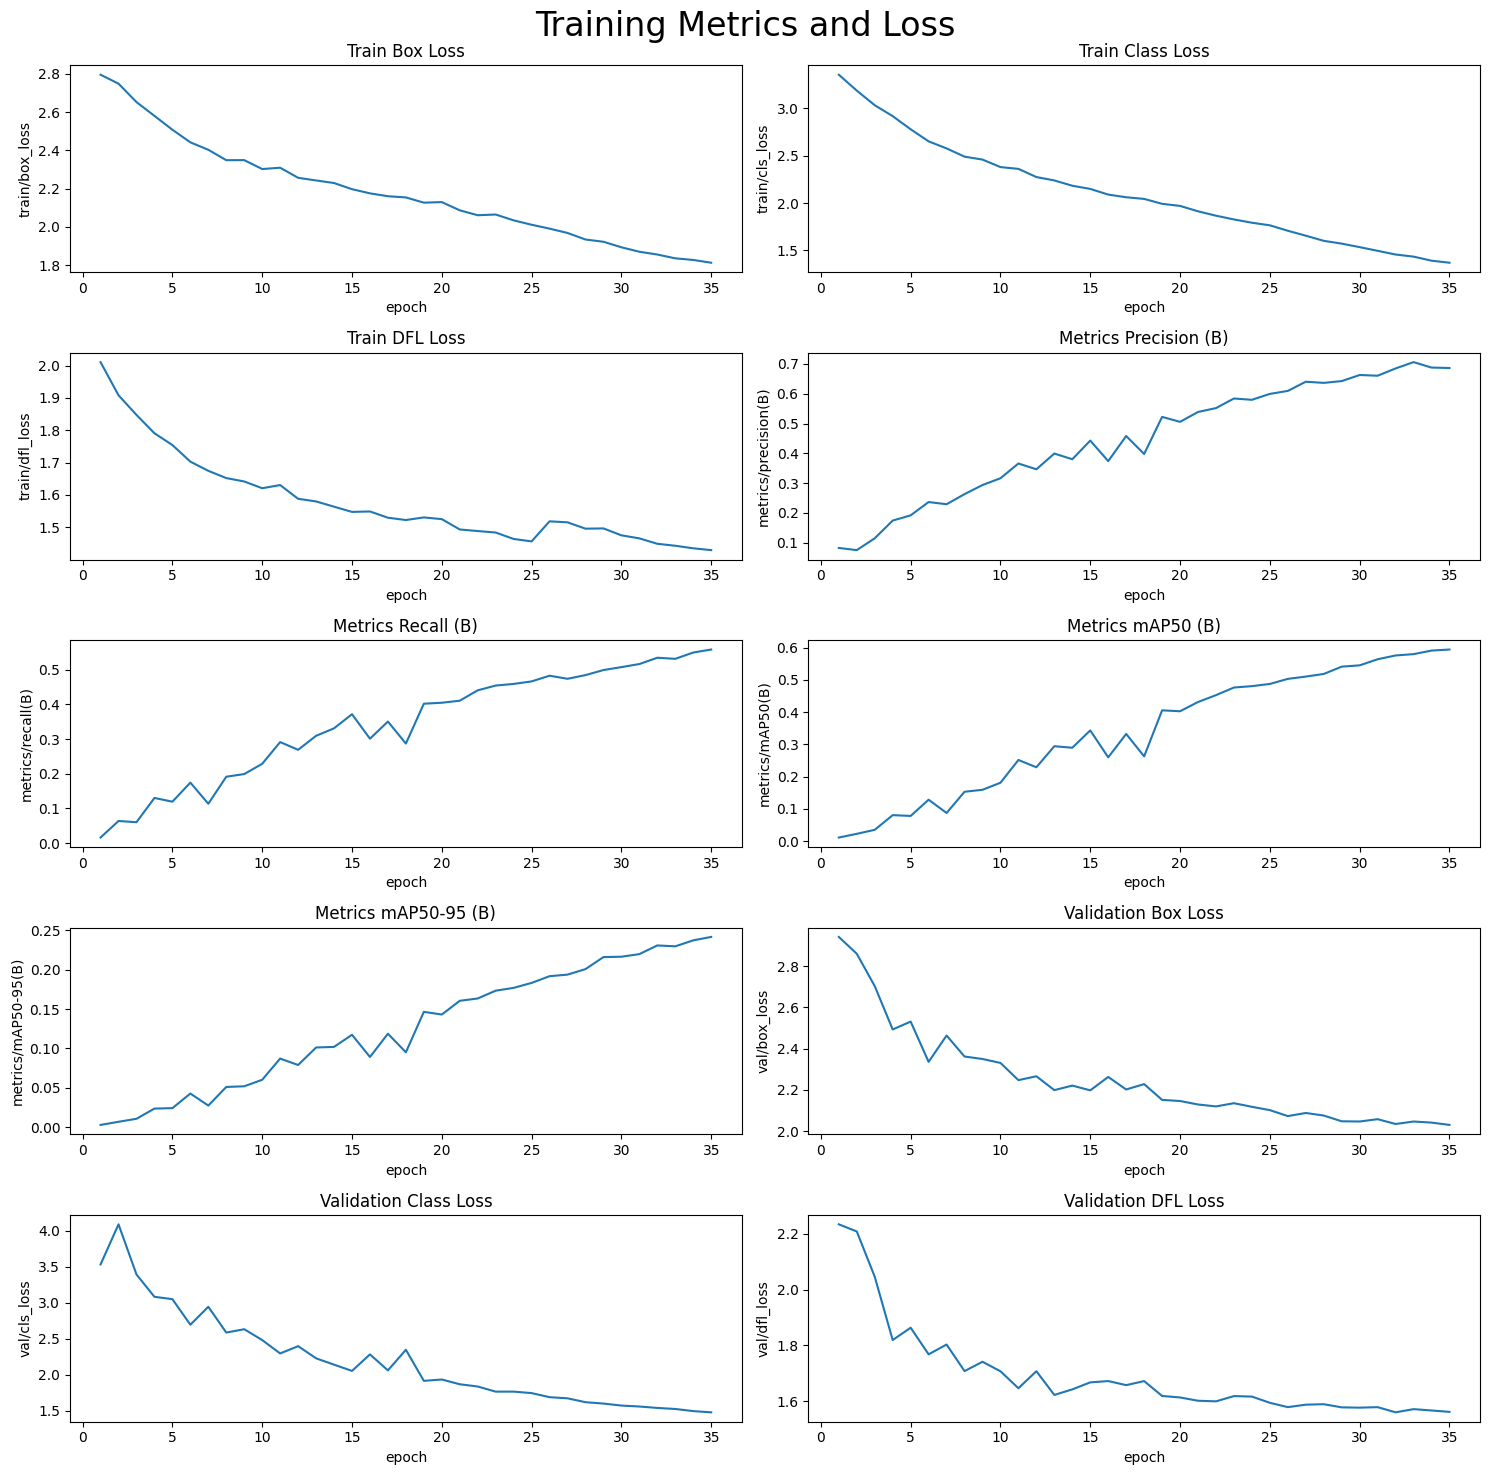

In [24]:
#VISUALIZACION DE LOS RESULTADOS DEL ENTRENAMIENTO
df = pd.read_csv('runs/detect/model_v112/results.csv')
df.columns = df.columns.str.strip()
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))


sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')


plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

In [25]:
#CARGAR EL MODELO ENTRENANDO
model_v11 = YOLO('runs/detect/model_v112/weights/best.pt') 

In [30]:
# EVALUACION DE LOS DATOS DE PRUEBA(TEST)
metrics_modelvl1 = model_v11.val(data='data4k_9k.yaml', split="test", imgsz=512)

Ultralytics 8.3.31  Python-3.9.20 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)


FileNotFoundError: 
Dataset 'data4k_9k.yaml' images not found ⚠️, missing path 'C:\Users\zekro\Desktop\Ivan\PostGradoUMSS\Estadistica\Final Project\YOLO-ROBOFLOW\Fracture_Detection_yolov8\Dataset 4K_9k\valid4k_9k\images'
Note dataset download directory is 'C:\Users\zekro\Desktop\Ivan\PostGradoUMSS\Estadistica\Final Project\YOLO-ROBOFLOW\Fracture_Detection_yolov8'. You can update this in 'C:\Users\zekro\AppData\Roaming\Ultralytics\settings.json'

In [39]:
precision = metrics_modelvl1.box.p
recall = metrics_modelvl1.box.r
mAP50 = metrics_modelvl1.box.map50
print("Evaluacion datos de prueba Modelo 4K_9K")
print("Precision: ", precision)
print("Recall: ", recall)
print("mAP50: ", mAP50)

Evaluacion datos de prueba Modelo 4K_9K
Precision:  [    0.72419]
Recall:  [    0.60016]
mAP50:  0.6625752178356552



0: 320x512 2 fractures, 178.4ms
Speed: 10.5ms preprocess, 178.4ms inference, 229.4ms postprocess per image at shape (1, 3, 320, 512)


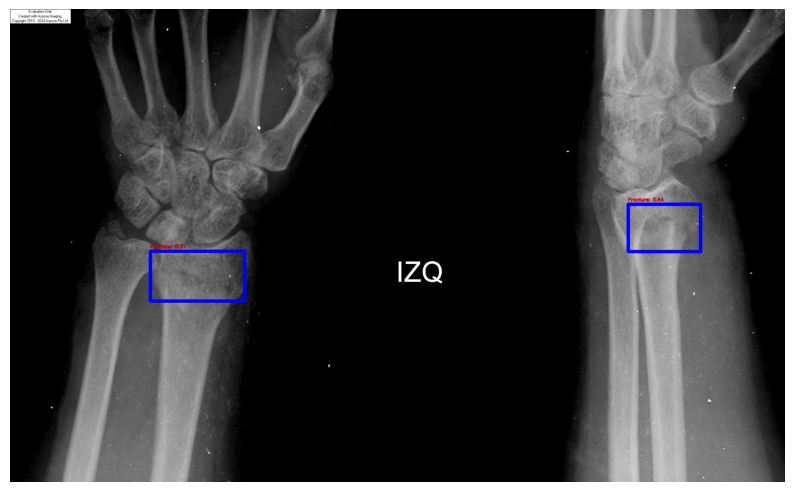

In [28]:
#TEST DE IMAGENS CNS
image_path = "Datos usados para evaluar CNS/364.dcm.png"
image = cv2.imread(image_path)


results = model_v11.predict(source=image, save=False, imgsz=512) 


for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  
        label = int(box.cls)  
        score = box.conf 

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 10)  
        cv2.putText(image, f'Fracture: {float(score):.2f}', (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2) 


# Convertir la imagen de BGR a RGB para mostrar con Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()